In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Init Plugin
Init Graph Optimizer
Init Kernel


### Constants and hyperparameters

In [2]:
epochs = 500 # Number of training epochs
batch_size = 12 # Batch size
split_percentage = 0.8 # Training and test set splitting percentage
validation_split = 0.2 # Validation set percentage
early_stopping_patience = 20 # Number of epochs of patience before triggering early stopping

In [3]:
dataset_path = "../Dataset/Sensors/Parallel/2D/Single NACA/2D_sensor__20x20__single_naca__x_y.npz" # Dataset path
labels = ["x", "y"] # Name of the labels
flow_field = "p" # Flow quantity to be used as input feature

### Data loading

In [4]:
# Loading the data
dataset = np.load(dataset_path)
dataset = list(zip(dataset[flow_field], *[dataset[label] for label in labels]))

In [5]:
print(len(dataset))

8133


### Shuffling the dataset

In [6]:
# Shuffling the dataset
np.random.shuffle(dataset)

### Features and labels

In [7]:
# Extracting the features and the labels from the dataset
X, *Y = zip(*dataset)
X, Y = np.array(X), np.array(Y).T

### Training and test set

In [8]:
# Computing the number of training samples according to the splitting percentage
num_training_samples = int(np.floor(split_percentage * len(dataset)))

In [9]:
# Extracting the training features and labels
X_train = np.expand_dims(X[:num_training_samples], axis=3)
Y_train = Y[:num_training_samples]

# Extracting the test features and labels
X_test = np.expand_dims(X[num_training_samples:], axis=3)
Y_test = Y[num_training_samples:]

### Data normalization

In [10]:
# Computing the mean and standard deviation of the training features
max = X_train.max()

In [11]:
# Function to normalize the features
def normalize(x):
    x *= 255.0 / max
    return x

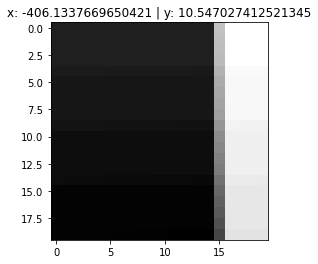

In [12]:
# Plotting a random sample
choice = np.random.randint(0, (len(X_train)-1))
plt.title(f'{"".join([(labels[i] + ": " + str(Y_train[choice][i]) + (" | " if i < len(labels) - 1 else "")) for i in range(len(labels))])}')
plt.imshow(X_train[choice][:,:,0], cmap="gray")
plt.show()

### Building the model

In [13]:

# BEST MODEL FOR SECTIONS X = [-1c, 2c]
def buildModel():
  # Sequential model - CNN 1D
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=np.shape(X_train)[1:]),
    keras.layers.Lambda(normalize),
    keras.layers.Conv2D(filters=24, kernel_size=(3, 3), activation=tf.nn.relu, padding="same"),
    keras.layers.AveragePooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, padding="same"),
    keras.layers.AveragePooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(60, tf.nn.relu),
    keras.layers.Dense(30, tf.nn.relu),
    keras.layers.Dense(30, tf.nn.relu),
    keras.layers.Dense(30, tf.nn.relu),
    keras.layers.Dense(np.shape(Y)[1])
  ])

  # Compiling the model
  model.compile(loss='mse', optimizer="adam", metrics=['mae'])
  
  return model

In [14]:
model = buildModel()
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 20, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 24)        240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 48)        10416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
______________________________________________

### Model training

In [15]:
# Early stopping with a predefined patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=early_stopping_patience,
    restore_best_weights=True,
    verbose=True
)

# Training the model
history = model.fit(
    X_train, 
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    shuffle=True,
    verbose=1,
    callbacks=[early_stopping]
)

2022-10-05 15:41:15.885768: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/500
434/434 [==============================] - 6s 12ms/step - loss: 42694.9375 - mae: 151.8274 - val_loss: 19097.3262 - val_mae: 103.6173
Epoch 2/500
434/434 [==============================] - 5s 11ms/step - loss: 17280.2559 - mae: 98.7174 - val_loss: 15370.1709 - val_mae: 95.4508
Epoch 3/500
434/434 [==============================] - 5s 11ms/step - loss: 15206.1855 - mae: 94.8974 - val_loss: 15051.5195 - val_mae: 95.9218
Epoch 4/500
434/434 [==============================] - 5s 11ms/step - loss: 14443.8555 - mae: 93.4639 - val_loss: 15621.1387 - val_mae: 97.7175
Epoch 5/500
434/434 [==============================] - 5s 11ms/step - loss: 14541.6016 - mae: 93.8315 - val_loss: 14647.1885 - val_mae: 97.3505
Epoch 6/500
434/434 [==============================] - 5s 11ms/step - loss: 14097.7432 - mae: 93.0734 - val_loss: 15668.4404 - val_mae: 94.7764
Epoch 7/500
434/434 [==============================] - 5s 11ms/step - loss: 14441.3662 - mae: 93.4218 - val_loss: 18524.3281 - val_mae

In [16]:
# Function to plot the metrics of training and validation
def plotHistory(history, training_metric, validation_metric, ylabel):
  plt.plot(history.history[training_metric], label=training_metric)
  plt.plot(history.history[validation_metric], label=validation_metric)
  plt.ylim([0, np.max(history.history[training_metric] + history.history[validation_metric])])
  plt.xlabel('Epoch')
  plt.ylabel(ylabel)
  plt.grid(True)
  plt.legend()
  plt.show()

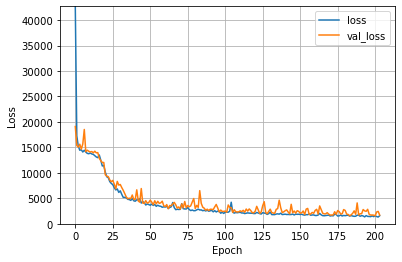

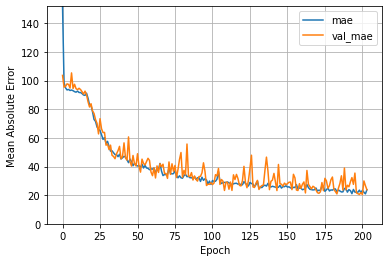

In [17]:
plotHistory(history, 'loss', 'val_loss', "Loss")
plotHistory(history, 'mae', 'val_mae', "Mean Absolute Error")

### Model evaluation

In [18]:
# Computing the predictions of the test set
predictions = model.predict(X_test)

In [19]:
def regressionMetrics(predictions, labels):
    # Creating an array to save the results
    mses, maes = np.zeros(np.shape(Y)[1]), np.zeros(np.shape(Y)[1])

    # Computing the Mean absolute error
    for idx in range(np.shape(Y)[1]):
        # Computing the Mean Absolute Error of the current NACA number
        mae = np.mean(np.absolute(predictions[:,idx] - labels[:,idx]))
        mse = ((predictions[:,idx] - labels[:,idx])**2).mean(axis=0)

        # Adding the result to the array
        mses[idx], maes[idx] = mse, mae

    return mses, maes

In [20]:
# Computing the regression errors: MSE and MAE
mse, mae = regressionMetrics(predictions, Y_test)

print("REGRESSION")
print(f" - Loss (Mean Square Error) --> {np.mean(mse)}")
print(f" - Mean Absolute Error --> {np.mean(mae)}")
for i in range(len(labels)):
    print(f"   • {labels[i]} --> MSE: {mse[i]} | MAE: {mae[i]}")


REGRESSION
 - Loss (Mean Square Error) --> 1272.9601478181894
 - Mean Absolute Error --> 19.04588042625249
   • x --> MSE: 1124.1714622341774 | MAE: 18.059139617577504
   • y --> MSE: 1421.7488334022014 | MAE: 20.03262123492748


In [21]:

# Function to plot the predicted values
def plotPredictions(test_labels, test_predictions, min_value, max_value, label, color):
  plt.scatter(test_labels, test_predictions, label=label, color=color)
  plt.xlabel('True values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([min_value, max_value])
  plt.ylim([min_value, max_value])
  plt.plot([min_value, max_value], [min_value, max_value], color="black")
  plt.legend()

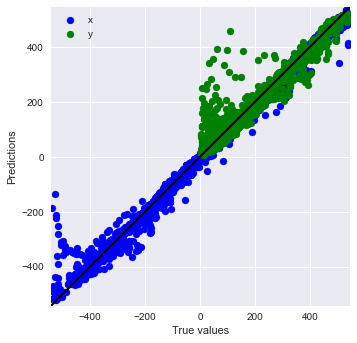

In [22]:
colors = ["blue", "green", "orange"]
max_value = np.max(Y_test.flatten())
min_value = np.min(Y_test.flatten())

plt.style.use('seaborn')

# Plotting the obtained results
for i in range(np.shape(Y)[1]):
  plotPredictions(Y_test[:,i], predictions[:,i], min_value, max_value, label=labels[i], color=colors[i])